# Various models for MIT BIH Dataset
The goal of this notebook is to compare different non-RNN architectures for MIT-BIH Arrhythmia Database: https://physionet.org/physiobank/database/mitdb/  
The data was downloaded from kaggle: https://www.kaggle.com/shayanfazeli/heartbeat  

We compare the results obtained with different trained networks with the CNN baseline.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from keras.engine.saving import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


# Read data

In [2]:
train_path = "../input/mitbih_train.csv"
test_path = "../input/mitbih_test.csv"

timepoints_per_sample = 187
df_train = pd.read_csv(train_path, header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv(test_path, header=None)

Y = np.array(df_train[timepoints_per_sample].values).astype(np.int8)
X = np.array(df_train[list(range(timepoints_per_sample))].values)[..., np.newaxis]

Y_test = np.array(df_test[timepoints_per_sample].values).astype(np.int8)
X_test = np.array(df_test[list(range(timepoints_per_sample))].values)[..., np.newaxis]

# Baseline results

Baseline model can be found at: https://github.com/CVxTz/ECG_Heartbeat_Classification/blob/master/code/baseline_mitbih.py

In [3]:
def get_baseline_resuts():

    Y = np.array(df_train[timepoints_per_sample].values).astype(np.int8)
    X = np.array(df_train[list(range(timepoints_per_sample))].values)[..., np.newaxis]

    Y_test = np.array(df_test[timepoints_per_sample].values).astype(np.int8)
    X_test = np.array(df_test[list(range(timepoints_per_sample))].values)[..., np.newaxis]

    file_path = "../saved_trained_models/baseline_cnn_mitbih.h5"

    model = load_model(file_path)

    pred_test = model.predict(X_test)
    pred_test = np.argmax(pred_test, axis=-1)

    f1 = f1_score(Y_test, pred_test, average="macro")
    acc = accuracy_score(Y_test, pred_test)

    return pred_test, f1, acc

# Compare new CNN with baseline
The following compares the results of the baseline CNN and our CNN implementation.

In [4]:
num_classes = 5
timepoints_per_sample = 187

# normalize without taking the zero-padding at the end into account:
for sample_idx in range(X.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X[sample_idx, 0: first_zero_sample, 0] -= np.mean(X[sample_idx, 0: first_zero_sample, 0])
    X[sample_idx, 0: first_zero_sample, 0] /= np.std(X[sample_idx, 0: first_zero_sample, 0])

for sample_idx in range(X_test.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X_test[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X_test[sample_idx, 0: first_zero_sample, 0] -= np.mean(X_test[sample_idx, 0: first_zero_sample, 0])
    X_test[sample_idx, 0: first_zero_sample, 0] /= np.std(X_test[sample_idx, 0: first_zero_sample, 0])

In [5]:
# final evaluation on test set
file_path = "../saved_trained_models/own_cnn_mitbih.h5"
model = load_model(file_path)
cnn_pred_test = model.predict(X_test)
cnn_pred_test = np.argmax(cnn_pred_test, axis=-1)

cnn_f1 = f1_score(Y_test, cnn_pred_test, average="macro")
cnn_acc = accuracy_score(Y_test, cnn_pred_test)

In [6]:
base_pred_test, base_f1, base_acc = get_baseline_resuts()

In [7]:
stats = pd.DataFrame({"model":[ "baseline","new CNN"], 
                      "accuracy":[base_acc, cnn_acc], 
                      "f1_score":[base_f1, cnn_f1]})

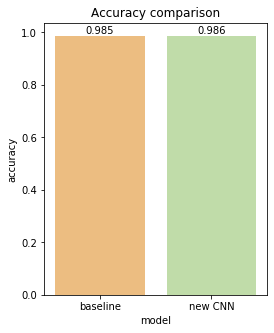

In [8]:
plt.figure(figsize=(4, 5))
splot = sns.barplot(x="model", y="accuracy", data=stats, palette="Spectral")
plt.title("Accuracy comparison")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

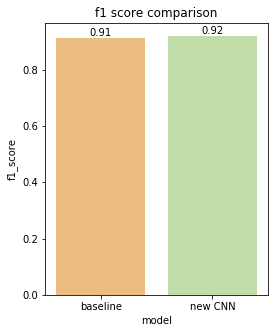

In [9]:
plt.figure(figsize=(4, 5))
splot = sns.barplot(x="model", y="f1_score", data=stats, palette="Spectral")
plt.title("f1 score comparison")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

The scores are very similar for the baseline and the new CNN.

# Compare ResNet with baseline
The following compares the results of the baseline CNN and the ResNet used in:  [ECG Heartbeat Classification: A Deep TransferableRepresentation](https://arxiv.org/pdf/1805.00794.pdf). 

In [10]:
# final evaluation on test set
file_path = "../saved_trained_models/paper_resnet_mitbih.h5"
model = load_model(file_path)
cnn_pred_test = model.predict(X_test)
cnn_pred_test = np.argmax(cnn_pred_test, axis=-1)

cnn_f1 = f1_score(Y_test, cnn_pred_test, average="macro")
cnn_acc = accuracy_score(Y_test, cnn_pred_test)

In [11]:
stats = pd.DataFrame({"model":[ "baseline","residual CNN"], 
                      "accuracy":[base_acc, cnn_acc], 
                      "f1_score":[base_f1, cnn_f1]})

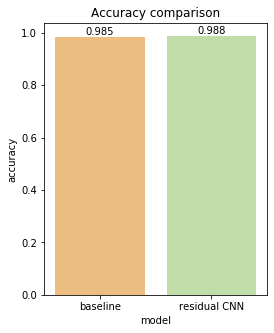

In [12]:
plt.figure(figsize=(4, 5))
splot = sns.barplot(x="model", y="accuracy", data=stats, palette="Spectral")
plt.title("Accuracy comparison")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

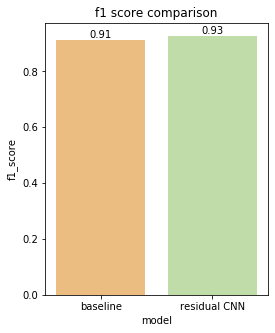

In [13]:
plt.figure(figsize=(4, 5))
splot = sns.barplot(x="model", y="f1_score", data=stats, palette="Spectral")
plt.title("f1 score comparison")
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

The residual CNN performs slightly better than the baseline.